# Intro to MACE

In this tutorial, you will learn how to fit a Message Passing Neural Network called `MACE`, which is a highly accurate and efficient MLIP. If you would like to understand this method in more detail, you can find the [original method paper](https://proceedings.neurips.cc/paper_files/paper/2022/file/4a36c3c51af11ed9f34615b81edb5bbc-Paper-Conference.pdf). MACE was developed by unifying the Atomic Cluster Expansion (ACE) approach with the Neural Equivariant Interatomic Potentials (NequIP). The mathematical formalism which unifies these methods is explained in the [accompaning paper](https://doi.org/10.48550/arXiv.2205.06643). Another [useful reference](https://doi.org/10.48550/arXiv.2305.14247) showcases the methods performance on published benchmark datasets. The [code implementation](https://github.com/ACEsuit/mace) is publically available and [here](https://mace-docs.readthedocs.io/en/latest/) you can find the accompaning documentation.

We will start by creating a simple potential on the same reference data from yesterday and reproduce the tests we used for GAP. We will then go beyond testing on fixed data and explore the stability of the potential in Molecular Dynamics (MD) simulations. We will test ideas of`iterative training` to improve the potential and `active learning` to automate the training process.

If the notebook stops responding (e.g. figures don't appear, the MACE fitting process stops or runs out of memmory), just restart the virtual machine in the "Environment" tab from the left menu.

In [1]:
%%bash
# Install GAP
pip install quippy-ase

# Install MACE
if test -d mace
then
    rm -rfv mace
fi
git clone --depth 1 --branch develop https://github.com/ACEsuit/mace.git 
pip install mace/

# Install extension to ASE
if test -d aseMolec
then
    rm -rfv aseMolec
fi
git clone --depth 1 https://github.com/imagdau/aseMolec.git
pip install aseMolec/

Defaulting to user installation because normal site-packages is not writeable
removed 'mace/setup.cfg'
removed 'mace/tests/__init__.py'
removed 'mace/tests/test_cg.py'
removed 'mace/tests/test_calculator.py'
removed 'mace/tests/test_data.py'
removed 'mace/tests/test_tools.py'
removed 'mace/tests/test_modules.py'
removed 'mace/tests/test_run_train.py'
removed 'mace/tests/test_models.py'
removed directory 'mace/tests'
removed 'mace/README.md'
removed 'mace/mace.egg-info/dependency_links.txt'
removed 'mace/mace.egg-info/requires.txt'
removed 'mace/mace.egg-info/PKG-INFO'
removed 'mace/mace.egg-info/top_level.txt'
removed 'mace/mace.egg-info/SOURCES.txt'
removed directory 'mace/mace.egg-info'
removed 'mace/.gitattributes'
removed 'mace/build/lib/tests/__init__.py'
removed 'mace/build/lib/tests/test_cg.py'
removed 'mace/build/lib/tests/test_calculator.py'
removed 'mace/build/lib/tests/test_data.py'
removed 'mace/build/lib/tests/test_tools.py'
removed 'mace/build/lib/tests/test_modules.py'
r

Cloning into 'mace'...


Defaulting to user installation because normal site-packages is not writeable
Processing ./mace
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for mace: filename=mace-0.2.0-py3-none-any.whl size=71048 sha256=b6ddf9ef82bd42df807201629ecfad074c1f245ddf6b729d05e30b0041b8ff6c
  Stored in directory: /tmp/ibatatia/2727521/pip-ephem-wheel-cache-yc6680th/wheels/53/13/2c/5b92ba6b53cdc311faa01f6294ac830e9ea592694e7a799702
Successfully built mace
  Attempting uninstall: mace
    Found existing installation: mace 0.2.0
    Uninstalling mace-0.2.0:
      Successfully uninstalled mace-0.2.0
removed 'aseMolec/README.md'
removed 'aseMolec/build/lib/aseMolec/ioLammps.py'
removed 'aseMolec/build/lib/aseMolec/_

Cloning into 'aseMolec'...


Defaulting to user installation because normal site-packages is not writeable
Processing ./aseMolec
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for aseMolec: filename=aseMolec-1.0.0-py3-none-any.whl size=22314 sha256=8da6fd962314c5aed671c1fef5d1089144ba1511ccf1b38db3f93e0bddf63edb
  Stored in directory: /tmp/ibatatia/2727521/pip-ephem-wheel-cache-d17dfb8a/wheels/0b/f6/49/afc613cf5e4f5a5e0681e1321f850345242f33c68a245b8f54
Successfully built aseMolec
  Attempting uninstall: aseMolec
    Found existing installation: aseMolec 1.0.0
    Uninstalling aseMolec-1.0.0:
      Successfully uninstalled aseMolec-1.0.0


# Fitting a Simple MACE Model

We will start by splitting the data into train and test sets the same as we did for GAP. In practice MACE extrapolates better than GAP, so we can get away with less data.

In [2]:
from ase.io import read, write

db = read('data/solvent_xtb.xyz', ':')

#non-periodic data is handled correctly by MACE, so we do not need to change anything
write('data/solvent_mace_train.xyz', db[:203])
write('data/solvent_mace_test.xyz', db[203:403])

/CSC_CONTAINER/miniconda/envs/env1/lib/python3.10/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


#### Training files

To train a MACE model, you will use the `run_train.py`command which takes the following arguments:

First specify the name of your model and final log file using the `--name` flag.

You can specify the training file with the `--train_file` flag. The validation set can either be specified as a separate file using the `--valid_file` keyword, or it can be specified as a fraction of the training set using the `--valid_fraction` keyword. The validation set is not used for optimizing the model but to estimate the model accuracy during training.

It is also possible to provide a test set using the `--test_file` keyword. This set is entirely independent and only gets evaluated at the end of the training process.

__________________

#### Reference energies

It is usually preferred to add the isolated atoms to the training set, rather than reading in their energies through the command line. MACE will automatically identify these atoms in the training set if they are labels correctly with `config_type=IsolatedAtom` in their `info` fields (we have done this yesterday when preparing the data). If you prefer not to use or do not know the energies of the isolated atoms, you can use the option `--E0s="average"` which estimates the atomic energies by least squares regression.

__________________


#### Model

##### The Messages

To control the model size, you need to change `--hidden_irreps`. For most applications, the recommended default model size is `--hidden_irreps='256x0e'` (meaning 256 invariant messages) or `--hidden_irreps='128x0e + 128x1o'` (meaning 128 equivariant messages). If the model is not accurate enough, you can include higher order features, e.g., `128x0e + 128x1o + 128x2e`, or increase the number of channels to `256`. The number of message passing layers can be controled via the `--num_ineractions` parameter. **Increasing the model size and the number of layers will lead to more accurate but slower models.**

##### Correlation order

MACE uses a body order expansion on the site energy:

$$
E_{i} = E^{(0)}_{i} + \sum_{j} E_{ij}^{(1)} + \sum_{jk} E_{ijk}^{(2)} + ...
$$

The correlation order corresponds to the order that MACE induces at each layer. Choosing `--correlation=3` will create basis function of up to 4-body (ijke) indices, for each layer. Because of the multiple layers of MACE, the total correlation order is much higher. A two layers mace, with `--correlation=3` has a total body order of 13.

##### Angular resolution

The angular resolution describes how precise the model can identify angles. This is controled by `l_max`. The higher this integer, more precise is the angular resolution. Larger value will result in more accurate but slower models. The default is `l_max=3`.

##### Cutoff radius

The cutoff radius controls the locality of the model. A `--r_max=3.0` means that the model assumes atoms seperated by a distance of more than 3.0 A do not directly `communicate`. Because the model has two layers, atoms further than 3.0 A can still `communicate` by proxy. The actual receptive field of the model is the number of layers times the cutoff distance.

__________________


#### Data keys

When parsing the data files the energies are read using the keyword `energy` and the forces using the keyword `forces`. To change that, specify the `--energy_key` and `--forces_key`.

__________________


#### Checkpoints

Fitting this model will take about `12 mins`. You can continue the fitting from the last checkpoint by using the flag `--restart_latest`. The checkpoint saves the best model that currently has been trained. All checkpoints are saved in ./checkpoints folder. We can also continue from a restart when extending the dataset.

__________________


#### Training parameters

These parameters are related to the training protocols: `--batch_size` represents the number of configs used to compute the gradients for each full update of all network parameters (stocastic gradient descent). The first `epoch` is completed when all the training data has been employed once in updating the weights and `--epochs` represents the number of such epochs. During training you will notice energy errors are at first much higher than force errors, MACE implements a special protocol that increases the weight on the energy in the loss function (`--swa_energy_weight`) once the forces are sufficiently accurate. The starting epoch for this special protocol can be controled by chaning `--start_swa`.

#### Validation parameters

The validation set controls the stopping of the training. At each `--eval_interval` the model is tested on the validation set. We also evaluate the set by batch size, controlled by `--valid_batch_size`. If the accuracy of the model stops improving on the validation set for `--patience` number of epochs. This is called **early stopping**.


We will start by training a very small model. **Feel free to play with the size of the model !**

In [5]:
!python3 ./mace/scripts/run_train.py \
    --name="model" \
    --train_file="data/solvent_mace_train.xyz" \
    --valid_fraction=0.05 \
    --test_file="maceTests/solvent_test.xyz" \
    --E0s="isolated" \
    --energy_key="energy" \
    --forces_key="forces" \
    --model="MACE" \
    --num_interactions=2 \
    --max_ell=2 \
    --hidden_irreps="16x0e" \
    --num_cutoff_basis=5 \
    --correlation=2 \
    --r_max=3.0 \
    --batch_size=5 \
    --valid_batch_size=5 \
    --eval_interval=1 \
    --max_num_epochs=50 \
    --start_swa=15 \
    --swa_energy_weight=1000 \
    --ema \
    --ema_decay=0.99 \
    --amsgrad \
    --error_table="PerAtomRMSE" \
    --default_dtype="float32" \
    --swa \
    --device=cpu \
    --seed=1234

2023-09-11 20:06:06.420 INFO: MACE version: 0.2.0
2023-09-11 20:06:06.420 INFO: Configuration: Namespace(name='model', seed=1234, log_dir='logs', model_dir='.', checkpoints_dir='checkpoints', results_dir='results', downloads_dir='downloads', device='cpu', default_dtype='float32', log_level='INFO', error_table='PerAtomRMSE', model='MACE', r_max=3.0, radial_type='bessel', num_radial_basis=8, num_cutoff_basis=5, interaction='RealAgnosticResidualInteractionBlock', interaction_first='RealAgnosticResidualInteractionBlock', max_ell=2, correlation=2, num_interactions=2, MLP_irreps='16x0e', radial_MLP='[64, 64, 64]', hidden_irreps='16x0e', num_channels=None, max_L=None, gate='silu', scaling='rms_forces_scaling', avg_num_neighbors=1, compute_avg_num_neighbors=True, compute_stress=False, compute_forces=True, train_file='data/solvent_mace_train.xyz', valid_file=None, valid_fraction=0.05, test_file='maceTests/solvent_test.xyz', E0s='isolated', energy_key='energy', forces_key='forces', virials_key='

# Testing MACE vs GAP

We will now evaluate the trained model on the test datasets we explored yesterday. For this, we can use the eval_configs.py code. One needs to specify the file to evaluate in `--configs`. The path to the model is in `--model`. The `--output` specifies to path of the output file where the predicted energies and forces of MACE are stored. The `--default_dtype="float32"`needs to match the one you used for training.

In [7]:
#evaluate the train set

!python3 ./mace/scripts/eval_configs.py \
    --configs="data/solvent_mace_train.xyz" \
    --model="model_swa.model" \
    --output="maceTests/solvent_train.xyz" \
    --default_dtype="float32" \
    --info_prefix=""

#evaluate the test set
!python3 ./mace/scripts/eval_configs.py \
    --configs="data/solvent_mace_test.xyz" \
    --model="model_swa.model" \
    --output="maceTests/solvent_test.xyz" \
    --default_dtype="float32" \
    --info_prefix=""

#evaluate the volume scan
!python3 ./mace/scripts/eval_configs.py \
    --configs="data/volumeScan.xyz" \
    --model="model_swa.model" \
    --output="maceTests/volumeScan.xyz" \
    --default_dtype="float32" \
    --info_prefix=""

We can compare MACE vs GAP accuracy on the train and test sets. The GAP model was fitted on the same data.

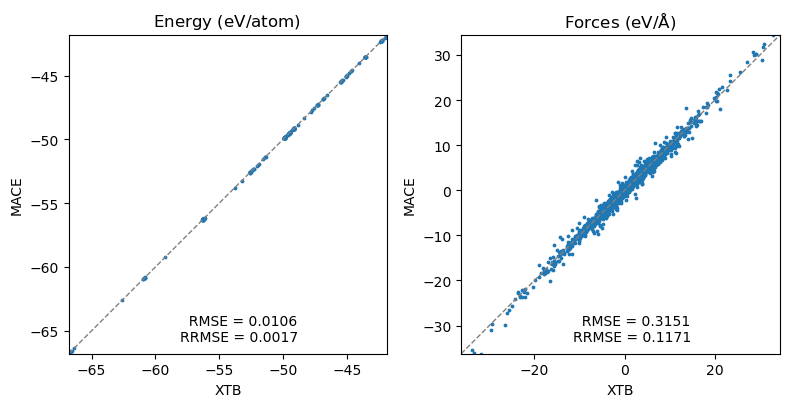

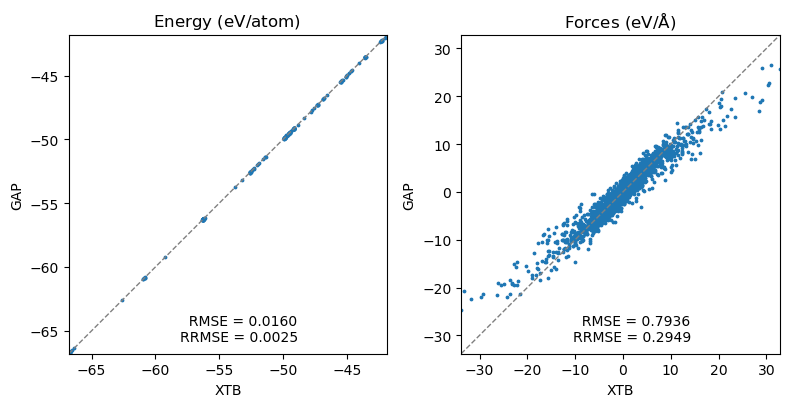

In [10]:
from aseMolec import pltProps as pp
from ase.io import read
import matplotlib.pyplot as plt
from aseMolec import extAtoms as ea 
import numpy as np

def plot_RMSEs(db1, db2, labs):
    plt.figure(figsize=(8,4), dpi=100)
    plt.subplot(1,2,1)
    pp.plot_prop(ea.get_prop(db1, 'info', 'energy', True).flatten(), \
                 ea.get_prop(db2, 'info', 'energy', True).flatten(), \
                 title=r'Energy $(\rm eV/atom)$ ', labs=labs, rel=True)
    plt.subplot(1,2,2)
    pp.plot_prop(np.concatenate(ea.get_prop(db1, 'arrays', 'forces')).flatten(), \
                 np.concatenate(ea.get_prop(db2, 'arrays', 'forces')).flatten(), \
                 title=r'Forces $\rm (eV/\AA)$ ', labs=labs, rel=True)
    plt.tight_layout()
    return

plot_RMSEs(read('data/solvent_mace_test.xyz', ':'), read('maceTests/solvent_test.xyz', ':'), labs=['XTB', 'MACE'])
plot_RMSEs(read('data/solvent_test.xyz', ':'), read('gapTests/solvent_test.xyz', ':'), labs=['XTB', 'GAP'])

MACE forces are twice as good! More importantly, MACE effective cutoff is larger than 3 A, do you recall what happed in GAP when we extend the cutoff?

We can also check the Intra/Inter splits:

['Nmols', 'Comp', 'energy', 'numbers', 'positions', 'molID', 'forces', 'forces_trans', 'forces_rot', 'forces_vib']


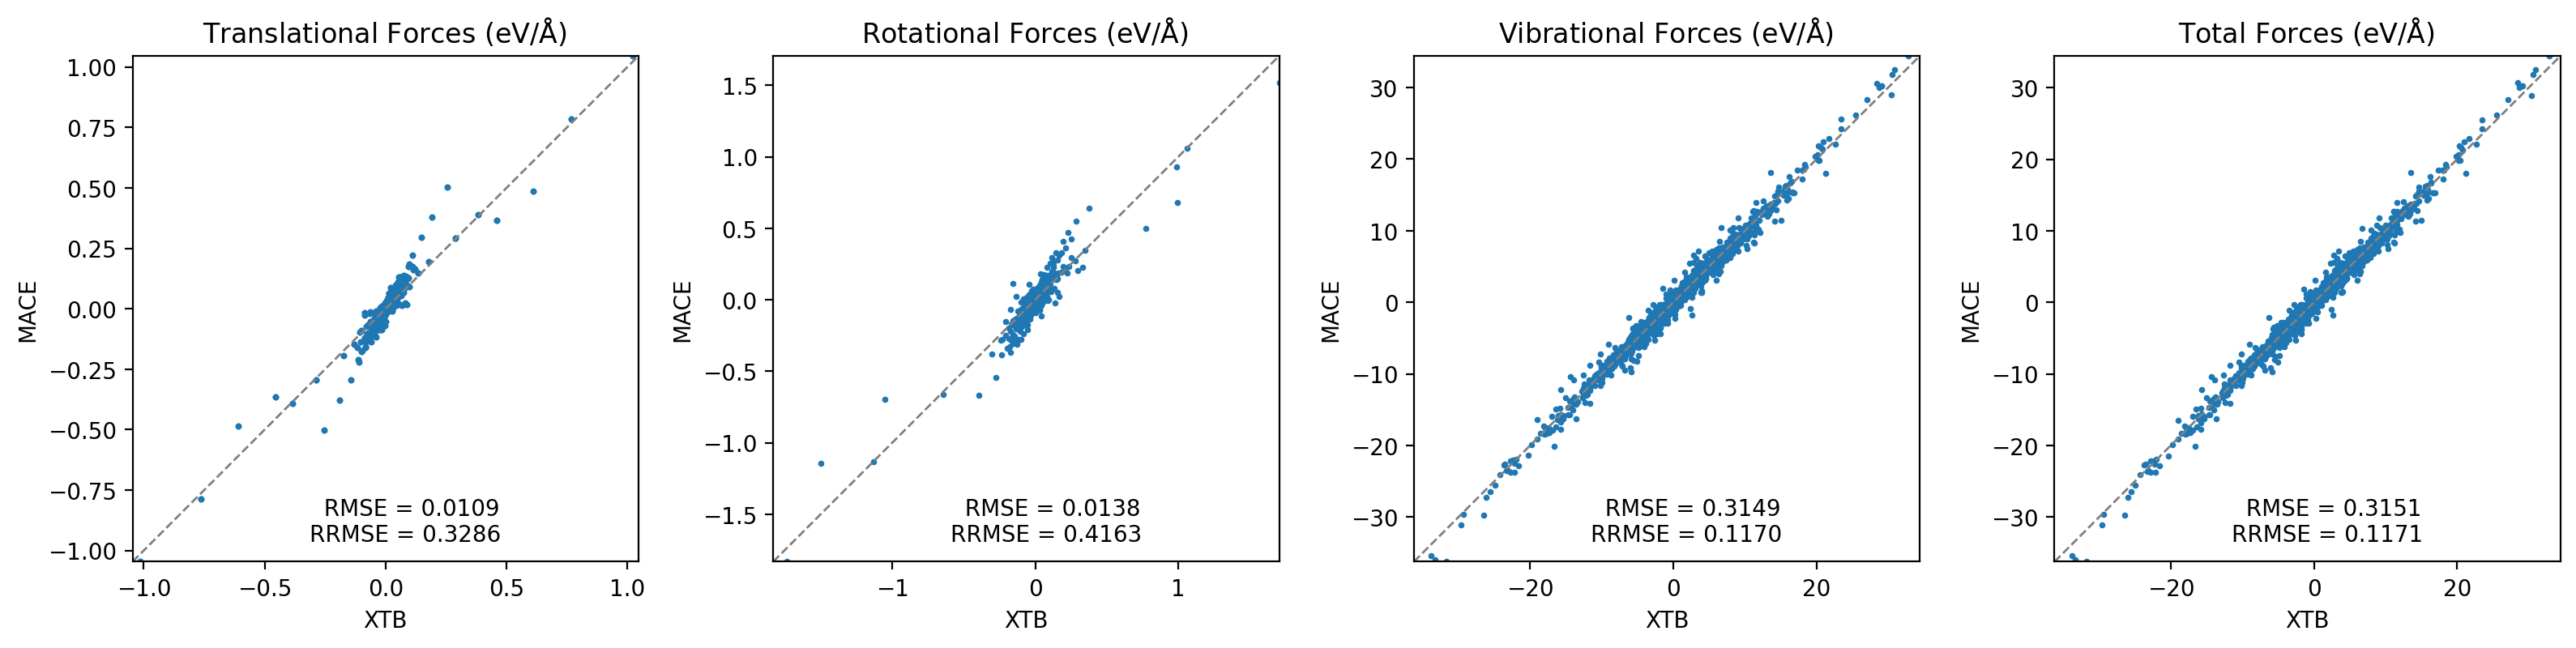

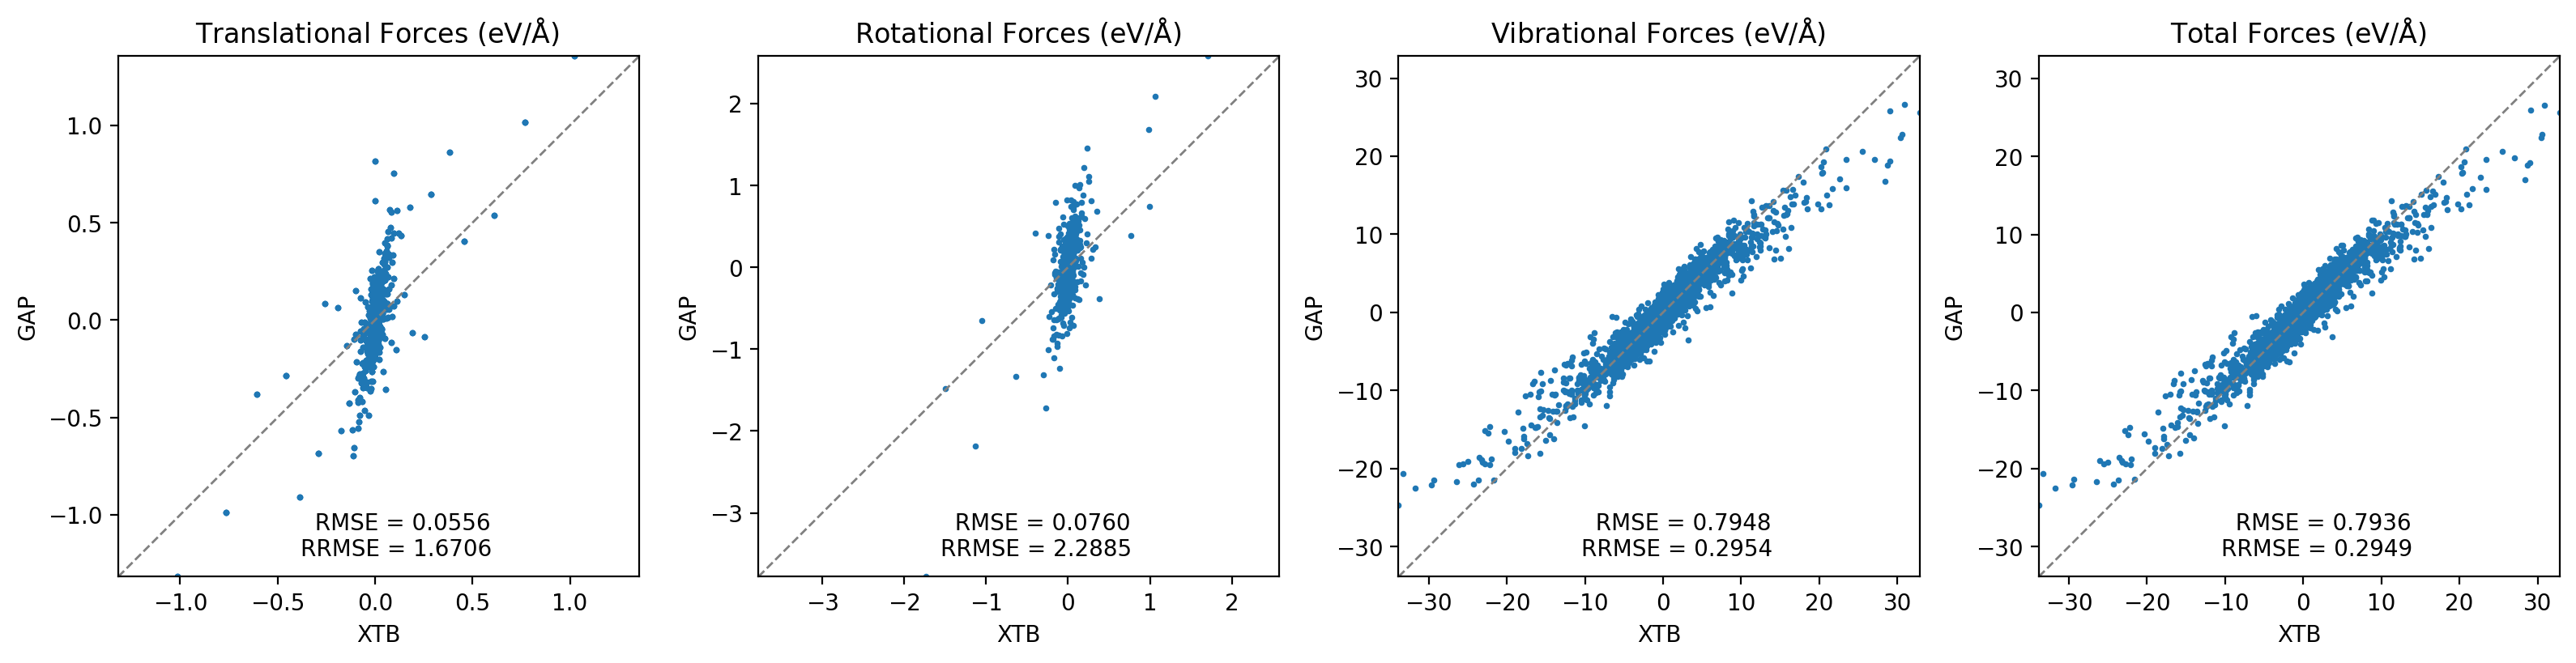

In [11]:
from aseMolec import pltProps as pp
from aseMolec import anaAtoms as aa

db1 = read('data/solvent_mace_test.xyz', ':')
db2 = read('maceTests/solvent_test.xyz', ':')

aa.extract_molecs(db1, intra_inter=True)
aa.extract_molecs(db2, intra_inter=True)

pp.plot_trans_rot_vib(db1, db2, labs=['XTB', 'MACE'])

db1 = read('data/solvent_test.xyz', ':')
aa.extract_molecs(db1, intra_inter=True)
ea.check_keys(db1[:1])
db2 = read('gapTests/solvent_test.xyz', ':')
aa.extract_molecs(db2, intra_inter=True)

pp.plot_trans_rot_vib(db1, db2, labs=['XTB', 'GAP'])

# Molecular Dynamics with MACE

MD is the ultimate test, let's check MACE stability. We will start by implementing a simple function to run Langevin dynamics. We will initialize the temperature at 300 K and remove all translations and rotations.

In [13]:
from ase.io import read, write
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution

import random
import os
import time
import numpy as np
import pylab as pl
from IPython import display

def simpleMD(init_conf, temp, calc, fname, s, T):
    init_conf.set_calculator(calc)

    #initialize the temperature
    random.seed(701) #just making sure the MD failure is reproducible
    MaxwellBoltzmannDistribution(init_conf, temperature_K=300) #initialize temperature at 300
    Stationary(init_conf)
    ZeroRotation(init_conf)

    dyn = Langevin(init_conf, 1.0*units.fs, temperature_K=temp, friction=0.1) #drive system to desired temperature

    %matplotlib inline

    time_fs = []
    temperature = []
    energies = []

    #remove previously stored trajectory with the same name
    os.system('rm -rfv '+fname)

    fig, ax = pl.subplots(2, 1, figsize=(6,6), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})

    def write_frame():
            dyn.atoms.write(fname, append=True)
            time_fs.append(dyn.get_time()/units.fs)
            temperature.append(dyn.atoms.get_temperature())
            energies.append(dyn.atoms.get_potential_energy()/len(dyn.atoms))

            ax[0].plot(np.array(time_fs), np.array(energies), color="b")
            ax[0].set_ylabel('E (eV/atom)')

            # plot the temperature of the system as subplots
            ax[1].plot(np.array(time_fs), temperature, color="r")
            ax[1].set_ylabel('T (K)')
            ax[1].set_xlabel('Time (fs)')

            display.clear_output(wait=True)
            display.display(pl.gcf())
            time.sleep(0.01)

    dyn.attach(write_frame, interval=s)
    t0 = time.time()
    dyn.run(T)
    t1 = time.time()
    print("MD finished in {0:.2f} minutes!".format((t1-t0)/60))

## Compare MACE, GAP and XTB Dynamics

Now we can run MD with MACE. Let's try 2 picoseoncds starting from a single molecule config:

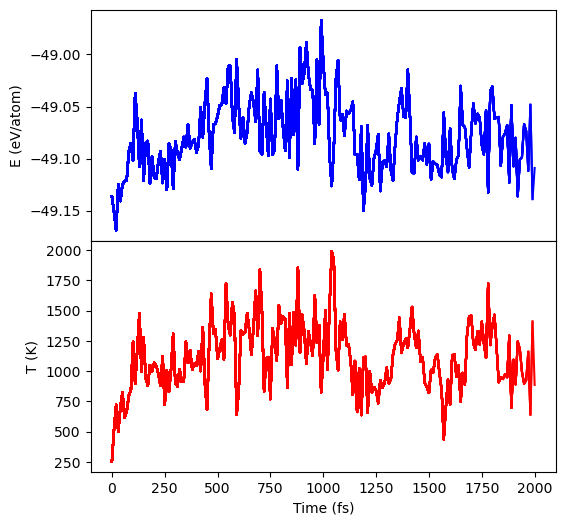

MD finished in 2.56 minutes!


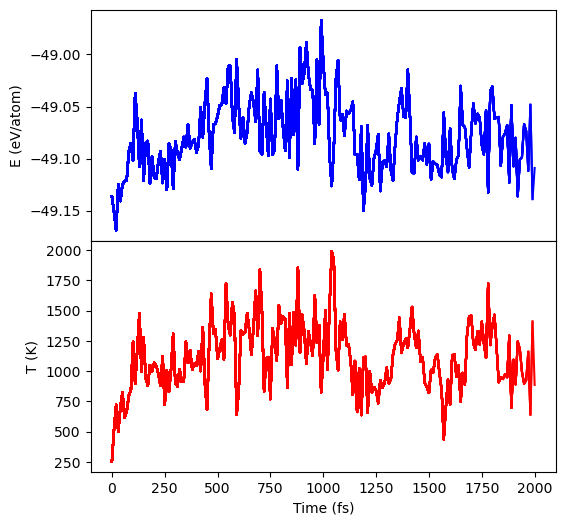

In [14]:
 #let us start with a single molecule
init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()

#we can use MACE as a calculator in ASE!
from mace.calculators import MACECalculator
mace_calc = MACECalculator(model_paths=['model_swa.model'], device='cpu', default_dtype="float32")


simpleMD(init_conf, temp=1200, calc=mace_calc, fname='mace_md.xyz', s=10, T=2000)


Let's also run some dynamics with the GAP potential fitted previously.

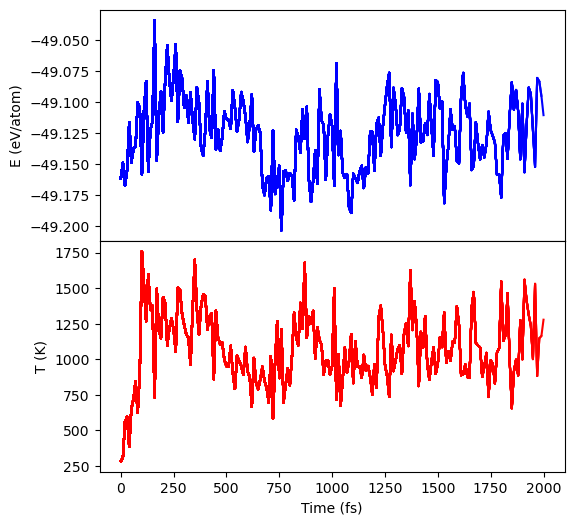

MD finished in 2.07 minutes!


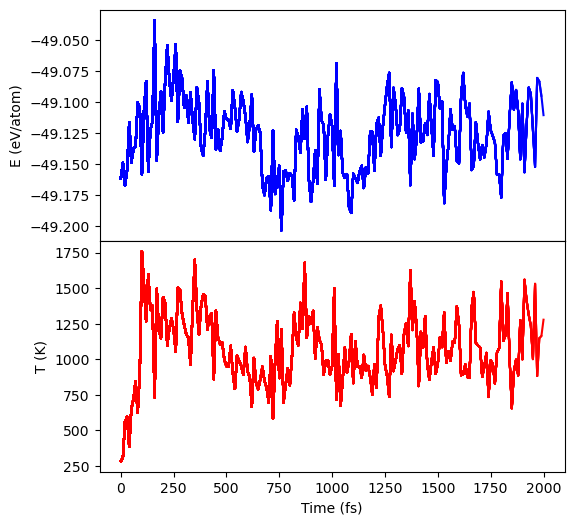

In [17]:
# reinitialize the original config
init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()

#we can use GAP as a calculator in ASE!
from quippy.potential import Potential
gap_calc = Potential("", param_filename="gapModels/GAP.xml")

simpleMD(init_conf, temp=1200, calc=gap_calc, fname='gap_md.xyz', s=10, T=2000)


For reference, we can also run XTB dynamics from the same starting configuration.

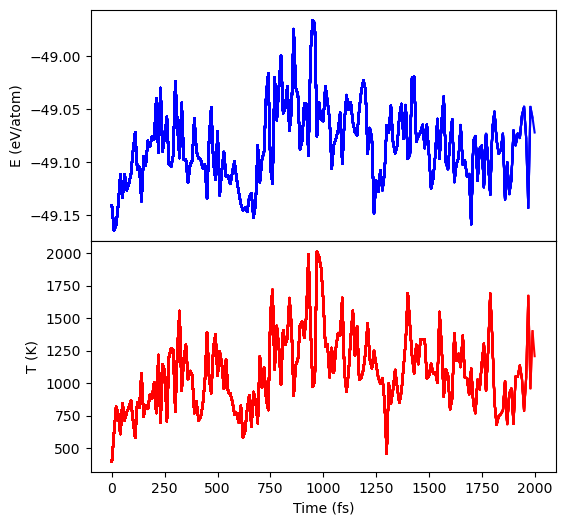

MD finished in 2.13 minutes!


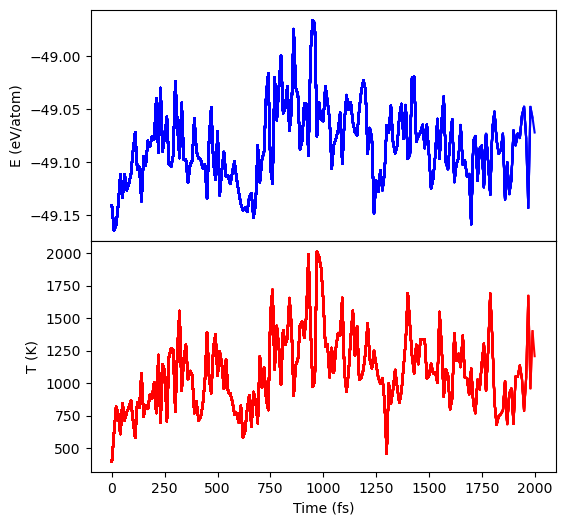

In [18]:
# reinitialize the original config
init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()

from xtb.ase.calculator import XTB
xtb_calc = XTB(method="GFN2-xTB")

simpleMD(init_conf, temp=1200, calc=xtb_calc, fname='xtb_md.xyz', s=10, T=2000)

Great the dynamics are pretty stable! Download the trajectory files `.xyz` and visualize them with your favourite software.

Are the different dynamics sampling the correct distributions? Let us check the radial distribution functions (RDF). The [aseMolec](https://github.com/imagdau/aseMolec) package provides functionality to do that:

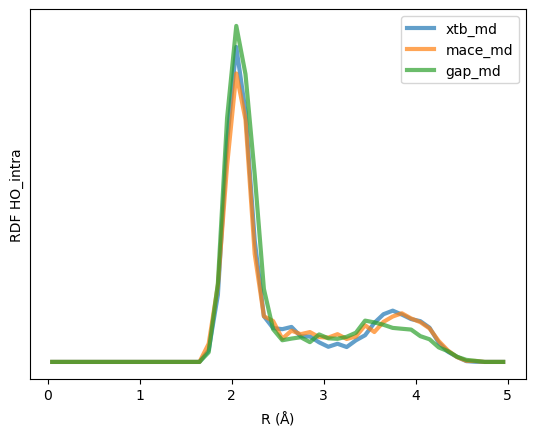

In [20]:
from aseMolec import anaAtoms as aa

tag = 'HO_intra' #choose one of 'HH_intra', 'HC_intra', 'HO_intra', 'CC_intra', 'CO_intra', 'OO_intra'

for f in ['xtb_md', 'mace_md', 'gap_md']:
    traj = read(f+'.xyz', ':')
    for at in traj:
        at.pbc = True
        at.cell = [100,100,100]
    rdf = aa.compute_rdfs_traj_avg(traj, rmax=5, nbins=50) #aseMolec provides functionality to compute RDFs
    plt.plot(rdf[1], rdf[0][tag], label=f, alpha=0.7, linewidth=3)

plt.legend();
plt.yticks([]);
plt.xlabel(r'R ($\rm \AA$)');
plt.ylabel('RDF '+tag);

Try it yourself! Look at other RDF types, how well are they reproduced? The MACE model performes better than GAP.

The trajectories here are pretty stable, but this is a pretty simple problem. We chose a single molecule at relatively small temperatures (for a molecule) and only ran for 2 picoseconds. In practice, given enough time and high enough temperature the initial models will fail.

Experiment with the starting configs, temperatures, simulation length, see if you can find problems with the potentials!

## The Molecular Liquid Condensed Phase

The MLIP was trained on clusters, can we simulate the liquid molecular environment?

In [ ]:
init_conf = read('data/ECEMC.xyz','4') #read a liquid config with periodic boundary conditions
init_conf.center()

simpleMD(init_conf, temp=500, calc=mace_calc, fname='liquid_md.xyz', s=10, T=2000)

This XTB calculator is non-periodic, so this dynamics would not be possible without an MLIP! Check for yourself, by replacing the calculator with xtb. The system is much larger than the example before (12 molecules vs just one), check how GAP scales with size by replacing the calculator with gap.


Transferability from clusters to the condensed phase environment is still an open research question. If this works, it implies that we might be able to learn on highly accuracte Quantum Chemistry methods on molecular clusters and make predictions (density, diffusivity) for the condensed phase! This is new Science!

# Active Learning with MACE

This is a short tutorial on how to use active learning with MACE.

Active learning consists is an iterative fitting process aiming at providing the model with the most optimal training data for increasing its performance. For any active learning sheme, two things are essential:

- A efficient data generation source, in our case molecular dynamics.
- A score function rating the utility of a given data to be trained

The score function in the case of interatomic potentials is usually correlated to the uncertainty of the prediction of the model for a given configuration. For neural networks potentials like MACE, a straightforward measure of uncertainty is the variance of the output over an ensemble of models.


To obtain a comittee from MACE, we need to train a committee of models and add some randomness to the optimization process. We can achieve this by changing the `--seed`.

Let us train three small MACE models to make sure they break for demo purposes. We will use different seeds for the three independent models. This will allow us to create a `comittee` of independent predictors. As we change hyper parameters, we will also change the `--name` of the model to make sure it saves seperatly.

In [ ]:
#prepare a much smaller training example, and let us pick independent data sets
from ase.io import read, write
db = read('data/solvent_xtb.xyz', ':')
write('data/solvent_mace_small1_train.xyz', db[:3]+db[3:53]) #
write('data/solvent_mace_small2_train.xyz', db[:3]+db[53:103])
write('data/solvent_mace_small3_train.xyz', db[:3]+db[103:153])

#train the first model
!python3 ./mace/scripts/run_train.py \
    --name="model_small1" \
    --train_file="data/solvent_mace_small1_train.xyz" \
    --valid_fraction=0.05 \
    --E0s="isolated" \
    --energy_key="energy" \
    --forces_key="forces" \
    --model="MACE" \
    --num_interactions=2 \
    --max_ell=2 \
    --hidden_irreps="16x0e" \
    --num_cutoff_basis=5 \
    --correlation=2 \
    --r_max=3.0 \
    --batch_size=5 \
    --valid_batch_size=5 \
    --eval_interval=1 \
    --max_num_epochs=50 \
    --start_swa=30 \
    --swa_energy_weight=1000 \
    --ema \
    --ema_decay=0.99 \
    --amsgrad \
    --error_table="PerAtomRMSE" \
    --default_dtype="float32" \
    --swa \
    --device=cpu \
    --seed=345

#train the second model
!python3 ./mace/scripts/run_train.py \
    --name="model_small2" \
    --train_file="data/solvent_mace_small2_train.xyz" \
    --valid_fraction=0.05 \
    --E0s="isolated" \
    --energy_key="energy" \
    --forces_key="forces" \
    --model="MACE" \
    --num_interactions=2 \
    --max_ell=2 \
    --hidden_irreps="16x0e" \
    --num_cutoff_basis=5 \
    --correlation=2 \
    --r_max=3.0 \
    --batch_size=5 \
    --valid_batch_size=5 \
    --eval_interval=1 \
    --max_num_epochs=50 \
    --start_swa=30 \
    --swa_energy_weight=1000 \
    --ema \
    --ema_decay=0.99 \
    --amsgrad \
    --error_table="PerAtomRMSE" \
    --default_dtype="float32" \
    --swa \
    --device=cpu \
    --seed=567

#train the thirds model
!python3 ./mace/scripts/run_train.py \
    --name="model_small3" \
    --train_file="data/solvent_mace_small3_train.xyz" \
    --valid_fraction=0.05 \
    --E0s="isolated" \
    --energy_key="energy" \
    --forces_key="forces" \
    --model="MACE" \
    --num_interactions=2 \
    --max_ell=2 \
    --hidden_irreps="16x0e" \
    --num_cutoff_basis=5 \
    --correlation=2 \
    --r_max=3.0 \
    --batch_size=5 \
    --valid_batch_size=5 \
    --eval_interval=1 \
    --max_num_epochs=50 \
    --start_swa=30 \
    --swa_energy_weight=1000 \
    --ema \
    --ema_decay=0.99 \
    --amsgrad \
    --error_table="PerAtomRMSE" \
    --default_dtype="float32" \
    --swa \
    --device=cpu \
    --seed=731

Now we can run dynamics with a commitee of models and look at the variance in the energy prediction. Because XTB is cheap enough we can compare that variance with the true error. Do they correlate?

In [ ]:
from aseMolec import extAtoms as ea
from ase import units
from ase.md.langevin import Langevin
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution
from ase.io import read, write

import random
import numpy as np
import time
import pylab as pl
from IPython import display

from xtb.ase.calculator import XTB
from mace.calculators import MACECalculator

model_paths = ['model_small1_swa.model','model_small2_swa.model', 'model_small3_swa.model']
xtb_calc = XTB(method="GFN2-xTB")
mace_calc = MACECalculator(model_paths=model_paths, device='cpu', default_dtype="float32")

init_conf = ea.sel_by_info_val(read('data/solvent_molecs.xyz',':'), 'Nmols', 1)[0].copy()
init_conf.set_calculator(mace_calc)

#initialize the temperature
random.seed(701)
MaxwellBoltzmannDistribution(init_conf, temperature_K=500)
Stationary(init_conf)
ZeroRotation(init_conf)

dyn = Langevin(init_conf, 1*units.fs, temperature_K=1200, friction=0.1)

%matplotlib inline

time_fs = []
temperature = []
energies_1 = []
energies_2 = []
energies_3 = []
variances = []
xtb_energies = []
true_errors = []

! rm -rfv committee_md.xyz
fig, ax = pl.subplots(3, 1, figsize=(8,8), sharex='all', gridspec_kw={'hspace': 0, 'wspace': 0})


def write_frame():
        at = dyn.atoms.copy()
        at.calc = xtb_calc
        xtb_energy = at.get_potential_energy()

        dyn.atoms.write('committee_md.xyz', append=True)
        time_fs.append(dyn.get_time()/units.fs)
        temperature.append(dyn.atoms.get_temperature())
        energies_1.append(dyn.atoms.calc.results["energies"][0]/len(dyn.atoms))
        energies_2.append(dyn.atoms.calc.results["energies"][1]/len(dyn.atoms))
        energies_3.append(dyn.atoms.calc.results["energies"][2]/len(dyn.atoms))
        variances.append(dyn.atoms.calc.results["energy_var"]/len(dyn.atoms))
        xtb_energies.append(xtb_energy/len(dyn.atoms))
        true_errors.append(np.var([dyn.atoms.calc.results["energy"],xtb_energy])/len(dyn.atoms))

        # subplot the variance of the energy as a function of the steps and the temperature as two subplots
        ax[0].plot(np.array(time_fs), np.array(variances), color="y")
        ax[0].plot(np.array(time_fs), np.array(true_errors), color="black")
        ax[0].set_ylabel(r'$\Delta$ E (eV$^2$/atom)')
        ax[0].legend(['Estimated Error', 'True Error'], loc='lower left')

        # plot the temperature of the system as subplots
        ax[1].plot(np.array(time_fs), temperature, color="r", label='Temperature')
        ax[1].set_ylabel("T (K)")

        ax[2].plot(np.array(time_fs), energies_1, color="g")
        ax[2].plot(np.array(time_fs), energies_2, color="y")
        ax[2].plot(np.array(time_fs), energies_3, color="olive")
        ax[2].plot(np.array(time_fs), xtb_energies, color="black")
        ax[2].set_ylabel("E (eV/atom)")
        ax[2].set_xlabel('Time (fs)')
        ax[2].legend(['E mace1', 'E mace2', 'E mace3', 'E xtb'], loc='lower left')

        display.clear_output(wait=True)
        display.display(fig)
        time.sleep(0.01)

dyn.attach(write_frame, interval=10)
dyn.run(2000)
print("MD finished!")

As expected, the dynamics has failed. In this case our reference PES is xtb which is cheap to evaluate so we can easily check the error on the fly. In practice we will be trainking MLIPs on expensive reference methods, where computing the true error on the fly is impractical. Notice when the dynamics `explodes`, the `true error` divergese, but crucially the `estimated error` also diverges.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9485f16f-d74c-4d11-8957-82dc887c5ba6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>